# MLP and CNN Experiments


Objective : To train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.


## 3.1 Using MLP

The objectives of this experiment are as follows:

1. **Train an MLP on the MNIST dataset**
   - Use a Multilayer Perceptron (MLP) with the following architecture:  
     - **Input layer:** Flattened 28×28 image  
     - **Hidden Layer 1:** 30 neurons  
     - **Hidden Layer 2:** 20 neurons  
     - **Output Layer:** 10 neurons (corresponding to the 10 digit classes)  
   - If computational resources are limited, use a **stratified subset** of the MNIST training dataset while keeping the **original test set** unchanged.

2. **Performance Comparison**
   - Compare the trained MLP model with **Random Forest** and **Logistic Regression** classifiers.  
   - Evaluate all models using the following metrics:  
     - Accuracy  
     - F1-score  
     - Confusion Matrix  
   - Analyze and discuss **misclassifications** observed across models.

3. **t-SNE Visualization**
   - Visualize **t-SNE embeddings** of the 20-neuron hidden layer for both **trained** and **untrained** MLP models.  
   - Compare the cluster separability of the 10 digit classes before and after training.

4. **Generalization Test on Fashion-MNIST**
   - Evaluate the trained MLP on the **Fashion-MNIST** dataset.  
   - Observe and discuss differences in performance and feature representations.  
   - Compare **t-SNE plots** of the 20-neuron layer embeddings for **MNIST** and **Fashion-MNIST** datasets.


Importing Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Setting Up Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():  # For Mac GPUs
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Working on device:", device)

Working on device: cpu


Setting the Random Seed

Setting a random seed ensures reproducibility by making all random operations—like matrix initialization and pixel masking—produce the same results every time. This allows consistent, verifiable experiments

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Loading the MNIST Dataset

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms — convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Load MNIST training and test datasets
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print("Train: X =", X_train.shape, "y =", y_train.shape)
print("Test: X =", X_test.shape, "y =", y_test.shape)

Train: X = (60000, 28, 28) y = (60000,)
Test: X = (10000, 28, 28) y = (10000,)


so in the training set we have 60000 images and shape of each image is 28x28 and this will be used as flattened input layer 

Plotting Some Images 

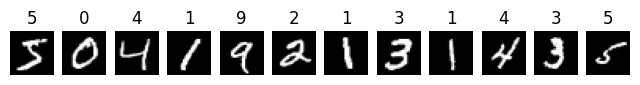

In [10]:
fig, axs = plt.subplots(1, 12, figsize=(8, 10))
for i in range(12):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

So we can see some of the handwritten digits and its labels above 

* Creating the MLP Model  : Input layer will have 784 neurons;hidden layer 1 will have 30 neurons; hidden layer 2 will have 20 neurons and output layer will have 10 neurons

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)  # Input layer → Hidden layer 1
        self.fc2 = nn.Linear(30, 20)     # Hidden layer 1 → Hidden layer 2
        self.fc3 = nn.Linear(20, 10)     # Hidden layer 2 → Output (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)            # No activation here; CrossEntropyLoss applies softmax internally
        return x


Initializing Model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)
summary(model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


Training The MLP

In [13]:
num_epochs = 10  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 0.4157
Epoch [2/10] Loss: 0.2051
Epoch [3/10] Loss: 0.1543
Epoch [4/10] Loss: 0.1298
Epoch [5/10] Loss: 0.1126
Epoch [6/10] Loss: 0.1022
Epoch [7/10] Loss: 0.0924
Epoch [8/10] Loss: 0.0844
Epoch [9/10] Loss: 0.0789
Epoch [10/10] Loss: 0.0732


Evaluating on the test set

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 96.53%


Train Accuracy: 97.80%
Test Accuracy:  96.53%
Train F1 Score: 0.9779
Test F1 Score:  0.9650


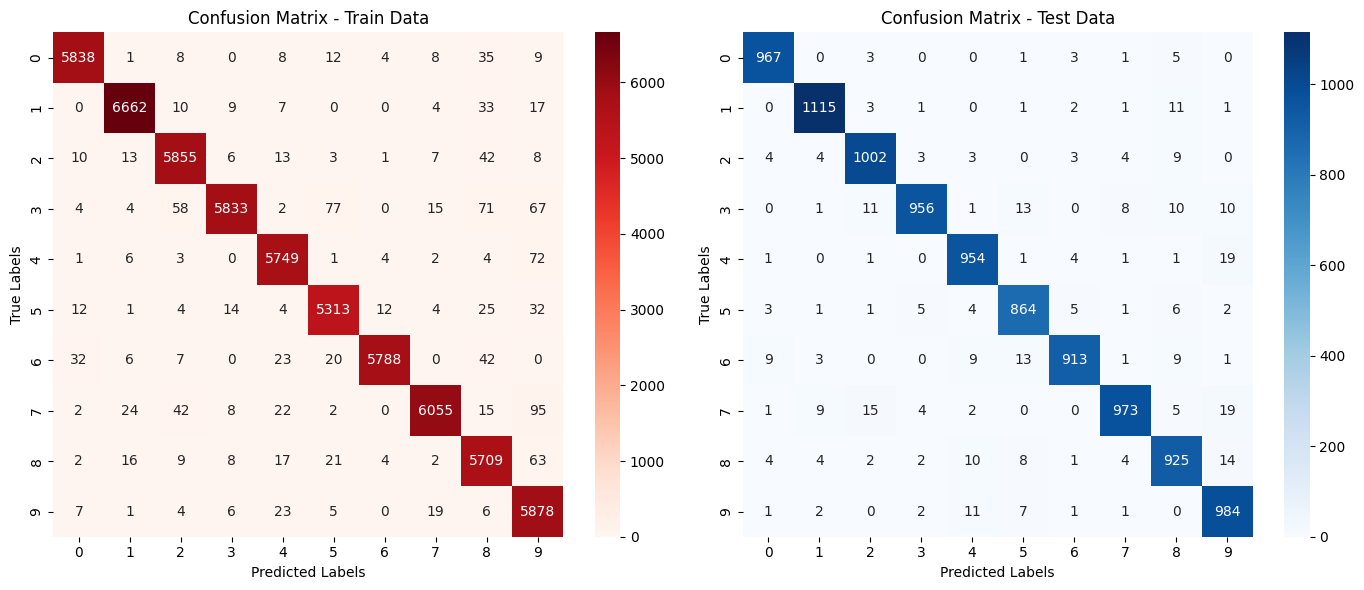

In [14]:
model.eval()


y_train_true = []
y_train_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_train_true.extend(target.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())


y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_test_true.extend(target.cpu().numpy())
        y_test_pred.extend(preds.cpu().numpy())

train_accuracy = accuracy_score(y_train_true, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_true, y_test_pred) * 100

f1_train = f1_score(y_train_true, y_train_pred, average='macro')
f1_test = f1_score(y_test_true, y_test_pred, average='macro')

cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:  {test_accuracy:.2f}%")
print(f"Train F1 Score: {f1_train:.4f}")
print(f"Test F1 Score:  {f1_test:.4f}")

# ----- Plot confusion matrices -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Reds', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [16]:
print('Test Data Classification Report For all Epochs:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report For all Epochs:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.95      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.95      0.97      0.96       892
           6       0.98      0.95      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Checking what it predicted wrong

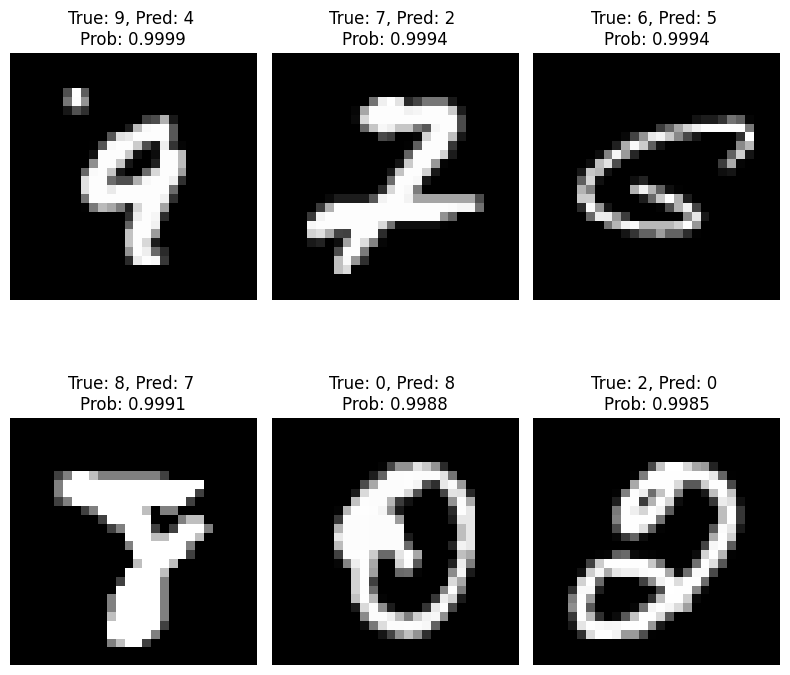

In [32]:
model.eval()
y_test_prob = []
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)                  # logits
        probs = F.softmax(outputs, dim=1)      # convert to probabilities
        y_test_prob.extend(probs.cpu().numpy())
        y_test_true.extend(target.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_test_pred.extend(preds.cpu().numpy())

y_test_prob = np.array(y_test_prob)
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

# --- Find misclassified samples ---
wrong_indices = np.where(y_test_true != y_test_pred)[0]
wrong_prob_max = np.max(y_test_prob[wrong_indices], axis=1)
topk = 6
topk_indices = np.argsort(wrong_prob_max)[::-1][:topk]

# --- Plot top-k misclassified images ---
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for i, idx in enumerate(topk_indices):
    ax = axs[i // 3, i % 3]
    img_idx = wrong_indices[idx]
    ax.imshow(X_test[img_idx], cmap='gray')
    ax.set_title(f'True: {y_test_true[img_idx]}, Pred: {y_test_pred[img_idx]} \nProb: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The next task is to compare the MLP trained models with random forest and logistic regression classifiers we can use scikit learn library

In [17]:
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat:", X_test_flat.shape)

X_train_flat: (60000, 784)
X_test_flat: (10000, 784)


In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_flat, y_train)

rf_train_pred = rf.predict(X_train_flat)
rf_test_pred = rf.predict(X_test_flat)

rf_train_acc = accuracy_score(y_train, rf_train_pred) * 100
rf_test_acc = accuracy_score(y_test, rf_test_pred) * 100

rf_train_f1 = f1_score(y_train, rf_train_pred, average='macro')
rf_test_f1 = f1_score(y_test, rf_test_pred, average='macro')

print(f"Random Forest → Train Acc: {rf_train_acc:.2f}% ; Test Acc: {rf_test_acc:.2f}%")
print(f"Random Forest → Train F1: {rf_train_f1:.4f} ; Test F1: {rf_test_f1:.4f}")


Random Forest → Train Acc: 100.00% ; Test Acc: 97.04%
Random Forest → Train F1: 1.0000 ; Test F1: 0.9702


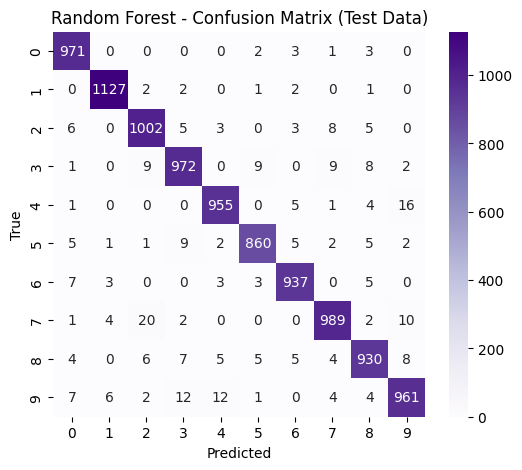

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Random Forest - Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_test_pred))

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
lr.fit(X_train_scaled, y_train)

lr_train_pred = lr.predict(X_train_scaled)
lr_test_pred = lr.predict(X_test_scaled)

lr_train_acc = accuracy_score(y_train, lr_train_pred) * 100
lr_test_acc = accuracy_score(y_test, lr_test_pred) * 100

lr_train_f1 = f1_score(y_train, lr_train_pred, average='macro')
lr_test_f1 = f1_score(y_test, lr_test_pred, average='macro')

print(f"Logistic Regression → Train Acc: {lr_train_acc:.2f}% | Test Acc: {lr_test_acc:.2f}%")
print(f"Logistic Regression → Train F1: {lr_train_f1:.4f} | Test F1: {lr_test_f1:.4f}")


c:\Users\Parth Dembla\Downloads\Machine Learning\ES-335-ML-Assignment-3\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression → Train Acc: 94.41% | Test Acc: 92.15%
Logistic Regression → Train F1: 0.9434 | Test F1: 0.9204


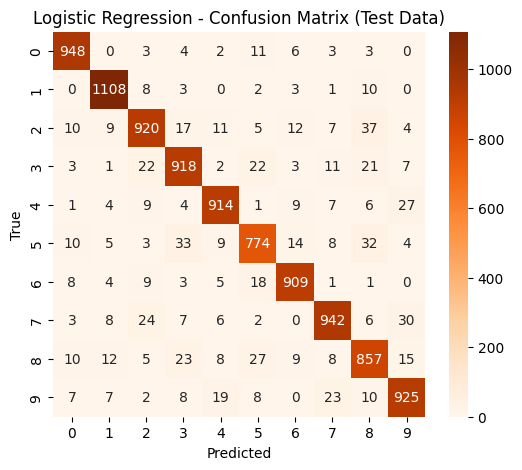

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.94      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [31]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, lr_test_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression - Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, lr_test_pred))


Compare all three models

In [26]:
comparison = {
    "Model": ["MLP", "Random Forest", "Logistic Regression"],
    "Train Accuracy (%)": [train_accuracy, rf_train_acc, lr_train_acc],
    "Test Accuracy (%)": [test_accuracy, rf_test_acc, lr_test_acc],
    "Train F1": [f1_train, rf_train_f1, lr_train_f1],
    "Test F1": [f1_test, rf_test_f1, lr_test_f1]
}

results_df = pd.DataFrame(comparison)
results_df


,Model,Train Accuracy (%),Test Accuracy (%),Train F1,Test F1
0,MLP,97.800000,96.53,0.977906,0.965045
1,Random Forest,100.000000,97.04,1.000000,0.970163
2,Logistic Regression,94.408333,92.15,0.943381,0.920447


ANALYSIS AND DISCUSSION ON COMPARISONS

Next task is to visualise TSNE Embeddings on 20 neuron hidden layer

In [32]:
from sklearn.manifold import TSNE

In [ ]:
class MLP_FeatureExtractor(MLP):
    def get_hidden_features(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        h = F.relu(self.fc2(x))   # 20-neuron layer activations
        return h

In [35]:
#  Untrained model 
untrained_model = MLP().to(device)
untrained_model.eval()

#  Trained model 
trained_model = model.to(device)
trained_model.eval()

#  Get a small subset for visualization (say 2000 samples)
subset_size = 2000
X_subset = torch.tensor(X_test[:subset_size], dtype=torch.float32).unsqueeze(1).to(device) / 255.0
y_subset = y_test[:subset_size]

with torch.no_grad():
    # Extract 20-D embeddings
    untrained_features = untrained_model.fc2(F.relu(untrained_model.fc1(X_subset.view(X_subset.size(0), -1)))).cpu().numpy()
    trained_features = trained_model.fc2(F.relu(trained_model.fc1(X_subset.view(X_subset.size(0), -1)))).cpu().numpy()

print("Feature shapes:", untrained_features.shape, trained_features.shape)


Feature shapes: (2000, 20) (2000, 20)


TSNE now will reduce 20 dimensional features to 2D

In [41]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

print("Running t-SNE on untrained features")
untrained_tsne = tsne.fit_transform(untrained_features)

print("Running t-SNE on trained features")
trained_tsne = tsne.fit_transform(trained_features)

print("run completed")


Running t-SNE on untrained features
Running t-SNE on trained features
run completed


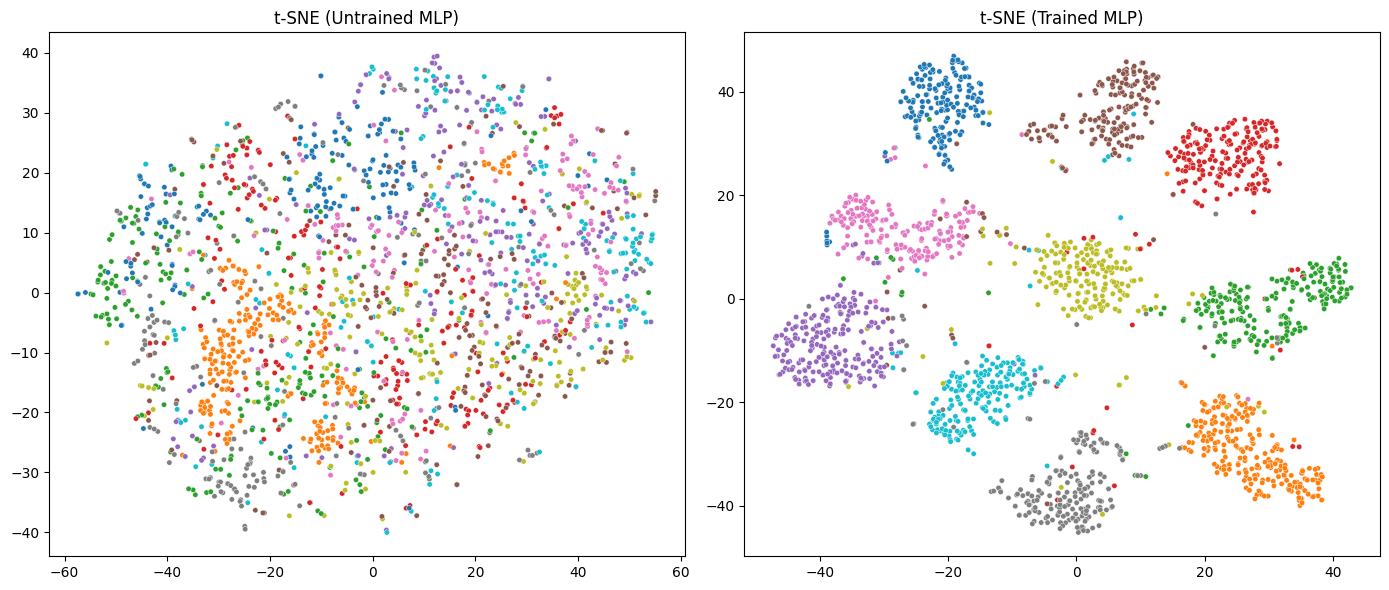

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#  Untrained
sns.scatterplot(x=untrained_tsne[:,0], y=untrained_tsne[:,1],
                hue=y_subset, palette="tab10", s=15, ax=axs[0], legend=False)
axs[0].set_title("t-SNE (Untrained MLP)")

# Trained 
sns.scatterplot(x=trained_tsne[:,0], y=trained_tsne[:,1],
                hue=y_subset, palette="tab10", s=15, ax=axs[1], legend=False)
axs[1].set_title("t-SNE (Trained MLP)")

plt.tight_layout()
plt.show()
